# Taylor Problem 16.14 version finite difference

Here we'll solve the wave equation for $u(x,t)$,

$\begin{align}
  \frac{\partial^2 u(x,t)}{\partial t^2} = c^2 \frac{\partial^2 u(x,t)}{\partial x^2}
\end{align}$

by a finite difference method, given its initial shape and velocity at $t=0$ from $x=0$ to $x=L$, with $L=1$,
The wave speed is $c=1$.

The shape is:

$\begin{align}
  u(x,0) = \left\{
             \begin{array}{ll}
              2x & 0 \leq x \leq \frac12  \\
              2(1-x) & \frac12 \leq x \leq 1
             \end{array}
           \right.
  \;,
\end{align}$

and the velocity is zero for all $x$ at $t=0$.  So this could represent the string on a guitar plucked at $t=0$.

* Created 03-Apr-2019. Last revised 06-Apr-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

**Template version: Add your own code where your see** `#***` **based on the equations below.**


## Background and equations

We will discretize $0 \leq x \leq L$ into the array `x_pts` with equal spacing $\Delta x$.  How do we find an expression for the second derivative in terms of points in `x_pts`?  Taylor expansion, of course!  Look at a step forward and back in $x$:

$\begin{align}
  u(x+\Delta x,t) &= u(x,t) + \frac{\partial u}{\partial x}\Delta x
                           + \frac12\frac{\partial^2 u}{\partial x^2}(\Delta x)^2
                           + \frac16\frac{\partial^3 u}{\partial x^3}(\Delta x)^3
                           + \mathcal{O}(\Delta x)^4 \\
  u(x-\Delta x,t) &= u(x,t) - \frac{\partial u}{\partial x}\Delta x
                           + \frac12\frac{\partial^2 u}{\partial x^2}(\Delta x)^2
                           - \frac16\frac{\partial^3 u}{\partial x^3}(\Delta x)^3
                           + \mathcal{O}(\Delta x)^4
\end{align}$

with all of the derivatives evaluated at $(x,t)$.

By adding these equations we eliminate all of the odd derivatives and can solve for the second derivative:

$\begin{align}
  \frac{\partial^2 u}{\partial x^2} = \frac{u(x+\Delta x,t) - 2 u(x,t) + u(x-\Delta x,t)}{(\Delta x)^2}
                           + \mathcal{O}(\Delta x)^2
\end{align}$

which is good to order $(\Delta x)^2$ rather than $\Delta x$ because of the cancellation of odd terms.
We get a similar expression for the time derivative by adding equations expanding to $t\pm \Delta t$. But instead of solving for the second derivative, we solve for $u$ at a time step forward in terms of $u$ at previous times:

$\begin{align}
  u(x, t+\Delta t) \approx 2 u(x,t) - u(x, t-\Delta t) + \frac{\partial^2 u}{\partial t^2}(\Delta t)^2
\end{align}$

and substitute the expression for $\partial^2 u/\partial x^2$, defining $c' \equiv \Delta x/\Delta t$.
So to take a time step of $\Delta t$ we use:

$\begin{align}
 u(x, t+\Delta t) \approx 2 u(x,t) - u(x, t-\Delta t) + \frac{c^2}{c'{}^2}
    [u(x+\Delta x,t) - 2 u(x,t) + u(x-\Delta x,t)]
  \qquad \textbf{(A)}
\end{align}$

**This is the equation to code for advancing the wave in time.**

To use the equation, we need to save $u$ for all $x$ at two consectutive times. We'll call those `u_past` and `u_present` and call the result of applying the equation `u_future`.  We have the initial $u(x,0)$ but to proceed to get $u(x,\Delta t)$ we'll still need $u(x,-\Delta t)$ while what we have is $\partial u(x,0)/\partial t$. We once again turn to a Taylor expansion:

$\begin{align}
  u(x, -\Delta t) = u(x,0) - \frac{\partial u(x,0)}{\partial t}(\Delta t) 
                   %  + \frac12 \frac{\partial^2 u}{\partial t^2}(\Delta t)^2 + \cdots \\
                 % &= u(x,0) - \frac{\partial u(x,0)}{\partial t}(\Delta t) 
                 %    + \frac12 \frac{c^2}{c'{}^2} [u(x+\Delta x,0) - 2 u(x,0) + u(x-\Delta x,0)]
  \qquad \textbf{(B)}
\end{align}$

and now we know both terms on the right side of $\textbf{(B)}$, so we can use this in $\textbf{(A)}$ to take the first step to $u(x, \Delta t)$.

\[Note: in the class notes an expression for $u(x, -\Delta t)$ was given that included a $(\Delta t)^2$ correction.  However, this doesn't work, so use $\textbf{(B)}$ instead.\]

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [30]:
class uTriangular():
    """
    uTriangular class sets up a wave at x_pts.  Now with finite difference.
     
    Parameters
    ----------
    x_pts : array of floats
        x positions of the wave 
    delta_t : float
        time step
    c : float
        speed of the wave
    L : length of the string

    Methods
    -------
    k(self, n)
        Returns the wave number given n.
    u_wave(self, t)
        Returns u(x, t) for x in x_pts and time t 
    """
    def __init__(self, x_pts, delta_t=0.00001, c_wave=1., L=1.):
        self.x_pts = x_pts
        self.delta_x = x_pts[1] - x_pts[0]
        self.delta_t = delta_t
        self.c_prime = self.delta_x / self.delta_t  # c' definition
        self.c = c_wave
        self.L = L
        self.t_now = self.delta_t
        self.u_start()  # set the starting functions
        
    
    def u_0(self, x):
        """Initial shape of string."""
        if (x <= self.L/2.):
            return 2.*x
        elif (x >= self.L/2.):
            return 2.*(1. - x)
        
#     def u_dot_0(self, x):
#         """Initial velocity of string."""
#         return 4. * x * (L - x)

    def u_dot_0(self, x):
        """Initialize velocity of string."""
        return 0.
    
    def u_start(self):
        """Initiate u_past and u_present."""
        self.u_present = np.zeros(len(x_pts))
        self.u_dot_present = np.zeros(len(x_pts))
        
        self.u_past = np.zeros(len(x_pts))
        for i in np.arange(1, len(x_pts) - 1):
            x = self.x_pts[i]
            self.u_present[i] = self.u_0(x)
            self.u_dot_present[i] = self.u_dot_0(x)
            
            self.u_past[i] += self.u_present[i] - self.u_dot_present[i] * self.delta_t
        self.t_now = 0.
                
    def k(self, n):
        """Wave number for n 
        """
        return n * np.pi / self.L    
        
    def u_wave_step(self):
        """Returns the wave at the next time step, t_now + delta_t.  
        """
        u_future = np.zeros(len(self.x_pts))  # initiate to zeros
        for i in np.arange(1, len(x_pts) - 1):
            u_future[i] = 2. * self.u_present[i] - self.u_past[i] + \
            (self.c_prime/self.c)**2 *(self.u_present[i+1] - 2.*self.u_present[i] + self.u_present[i -1])
            
        # update past and present u
        self.u_past = self.u_present
        self.u_present = u_future
        
        return u_future
    
    def u_wave_at_t(self, t):
        """
        Returns the wave at time t by calling u_wave_step multiple times
        """
            
        self.u_start()   # reset to the beginning for now (sets t_now=0)
        if (t < self.delta_t):
            return self.u_present
        else:        
            for step in np.arange(self.t_now, t+self.delta_t, self.delta_t):
                u_future = self.u_wave_step()
        return u_future    
        

First look at the initial ($t=0$) wave form.

delta_t =  0.0099
c_prime =  1.01010101010101
c wave =  1.0


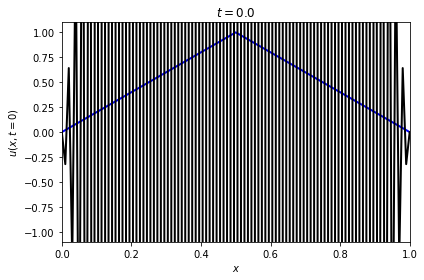

In [31]:
L = 1.
c_wave = 1.
omega_1 = np.pi * c_wave / L
tau = 2.*np.pi / omega_1

# Set up the array of x points (whatever looks good)
x_min = 0.
x_max = L
delta_x = 0.01
x_pts = np.arange(x_min, x_max + delta_x, delta_x)

# Set up the t mesh for the animation.  The maximum value of t shown in
#  the movie will be t_min + delta_t * frame_number
t_min = 0.   # You can make this negative to see what happens before t=0!
t_max = 2.*tau
delta_t = 0.0099
print('delta_t = ', delta_t)
t_pts = np.arange(t_min, t_max + delta_t, delta_t)

# instantiate a wave
u_triangular_1 = uTriangular(x_pts, delta_t, c_wave, L)
print('c_prime = ', u_triangular_1.c_prime)
print('c wave = ', u_triangular_1.c)

# Make a figure showing the initial wave.
t_now = 0.
u_triangular_1.u_start()

fig = plt.figure(figsize=(6,4), num='Standing wave')
ax = fig.add_subplot(1,1,1)
ax.set_xlim(x_min, x_max)
gap = 0.1
ax.set_ylim(-1. - gap, 1. + gap)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u(x, t=0)$')
ax.set_title(rf'$t = {t_now:.1f}$')

line, = ax.plot(x_pts, 
                u_triangular_1.u_present, 
                color='blue', lw=2)

# add a line at a later time
line_2, = ax.plot(x_pts, 
                 u_triangular_1.u_wave_at_t(0.5), 
                 color='black', lw=2)

fig.tight_layout()


Next make some plots at an array of time points.

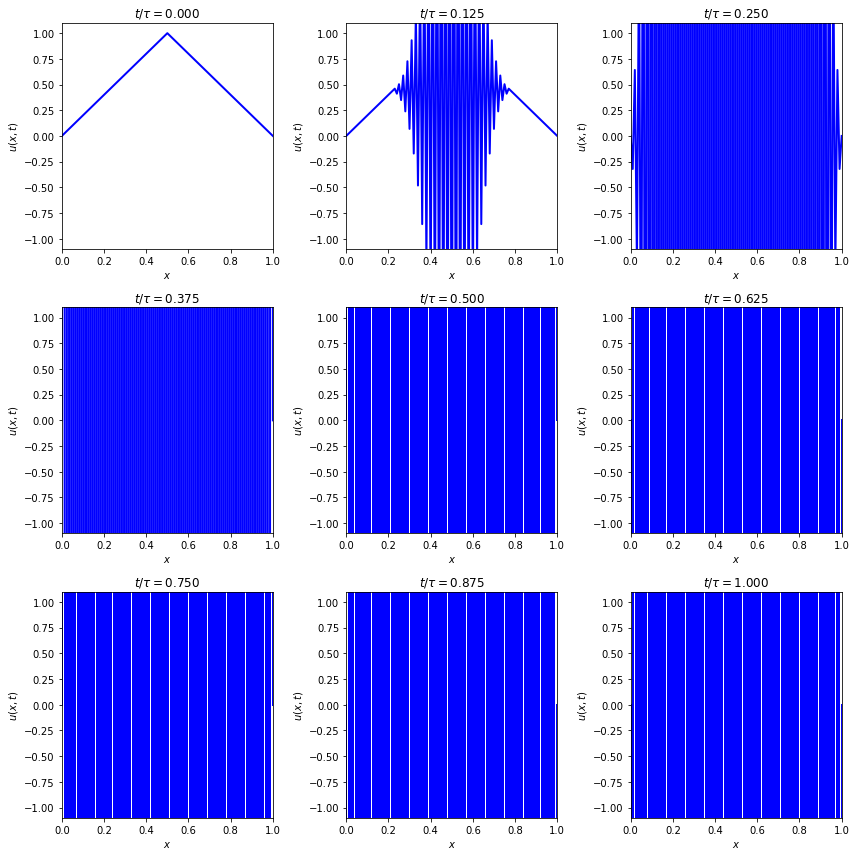

In [32]:
t_array = tau * np.arange(0, 1.125, .125)

fig_array = plt.figure(figsize=(12,12), num='Triangular wave')

for i, t_now in enumerate(t_array): 
    ax_array = fig_array.add_subplot(3, 3, i+1)
    ax_array.set_xlim(x_min, x_max)
    gap = 0.1
    ax_array.set_ylim(-1. - gap, 1. + gap)
    ax_array.set_xlabel(r'$x$')
    ax_array.set_ylabel(r'$u(x, t)$')
    ax_array.set_title(rf'$t/\tau = {t_now/tau:.3f}$')

    ax_array.plot(x_pts, 
                  u_triangular_1.u_wave_at_t(t_now), 
                  color='blue', lw=2)

fig_array.tight_layout()
fig_array.savefig('Taylor_Problem_16p14_finite_difference.png', 
                   bbox_inches='tight')  

Now it is time to animate!

We use the cell "magic" `%%capture` to keep the figure from being shown here.  If we didn't the animated version below would be blank.

In [10]:
%%capture

fig_anim = plt.figure(figsize=(6,3), num='Triangular wave')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
gap = 0.1
ax_anim.set_ylim(-1. - gap, 1. + gap)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
u_triangular_1.u_start()
line_anim, = ax_anim.plot(x_pts, 
                          u_triangular_1.u_wave_at_t(t_min), 
                          color='blue', lw=2)

fig_anim.tight_layout()

In [11]:
def animate_wave(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i.
    """
    t = t_pts[i]
    y_pts = u_triangular_1.u_wave_at_t(t)

    line_anim.set_data(x_pts, y_pts)  # overwrite line_anim with new points
    #return line_anim   # this is needed for blit=True to work

In [12]:
frame_interval = 80.  # time between frames
frame_number = 201    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_wave, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=False,
                               repeat=False)


In [13]:
HTML(anim.to_jshtml())      # animate using javascript
